<a href="https://colab.research.google.com/github/marcelarosalesj/e2e-vision-apps/blob/main/Week_4_Project_Build_a_Movie_Poster_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).

# Week 4 Project: Building a Movie Poster Generator

Welcome to the fourth week's project for *Building Computer Vision Applications*!

In this final week, we are going to get familiar with the key steps of machine learning, with a particular focus on image generation. Specifically, we will cover:

* finding pretrained image generation models from the Hugging Face Hub 👾
* using models to generate specific kinds of images through prompt-engineering 📖
* learning how to pipe machine learning models together to build more complex pipelines 🔧
* deploying the model as an app you can run on your phone or laptop 📷
* collecting data from real-world usage of the app to further improve the model  📈


# Introduction

[Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) is an open-source image generation model released in August 2022. The model uses machine learning to generate images from text prompts. It also has other uses, such as converting sketches into realistic images as well as learning new "concepts" to create custom images. Although other image generation models such as Midjourney and Dall-E exist, Stable Diffusion has the advantage of being completely open-source, while generating images of similar quality. Here is an example of the same prompt being fed into each of the three models:


![](https://www.artificialintelligence-news.com/wp-content/uploads/sites/9/2022/08/stable-diffusion-text-to-image-ai-model-generator-stability.jpeg)


Around the same time, Hugging Face released the `diffusers` library to make it very easy to work with Stable Diffusion as well as other models based on the same underlying "diffusion" algorithm. We will be using the `diffusers` library to generate images from the Stable Diffusion model. In particular, we will be generating movie posters that don't exist! By the end of the project, you will create an app that allows you put the name of a celebrity and the name of a movie and you'll produce a movie poster with them in it:

![](https://i.ibb.co/QMPMsvz/image.png)

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your colab notebook may restart once you make the change.

We're going to be using several fantastic open-source Python libraries to load our model (`transformers` and `diffusers`) and to build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [1]:
!pip install transformers huggingface_hub diffusers gradio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Step 1: Loading a Pretrained Diffusion Model

* First, we'll load the pretrained Stable Diffusion model and use it to generate "*a photo of an astronaut riding a horse on mars*". In order to use Stable Diffusion, you first need to agree to the terms and conditions. First, make sure that you are logged into your Hugging Face account:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


* Then, go to [Stable Diffusion model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree with the terms to use the model. Once you do that, you should be able to run the following lines of code to start generating images (might take a couple of minutes to download all of the model files the first time you run this):

*Note*: We suggest only running the following cell *once*. Since the model is loaded into memory, you may run out of memory if you rerun this cell multipletimes.

In [3]:
# make sure you're logged in with `huggingface-cli login`
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/51 [00:00<?, ?it/s]

* Let's see the image that you generated:

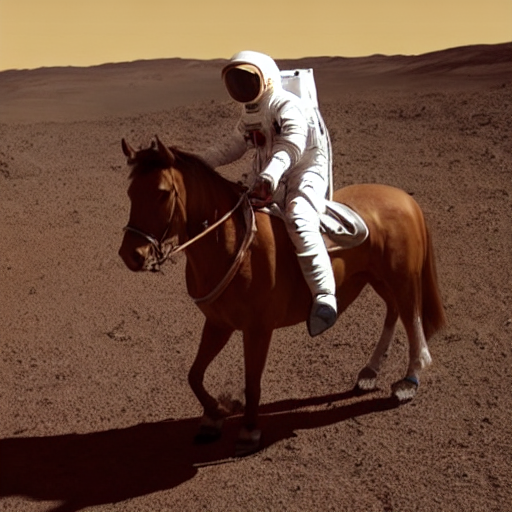

In [4]:
image

* Generate and display three more images with the same prompt.

In [5]:
images = []
for index in range(3):
  print(index)
  img = pipe(prompt)
  images.append(img)

0


  0%|          | 0/51 [00:00<?, ?it/s]

1


  0%|          | 0/51 [00:00<?, ?it/s]

2


  0%|          | 0/51 [00:00<?, ?it/s]

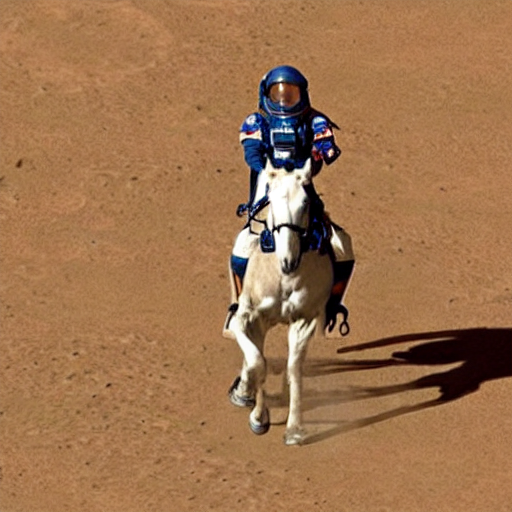

In [6]:
images[0].images[0]

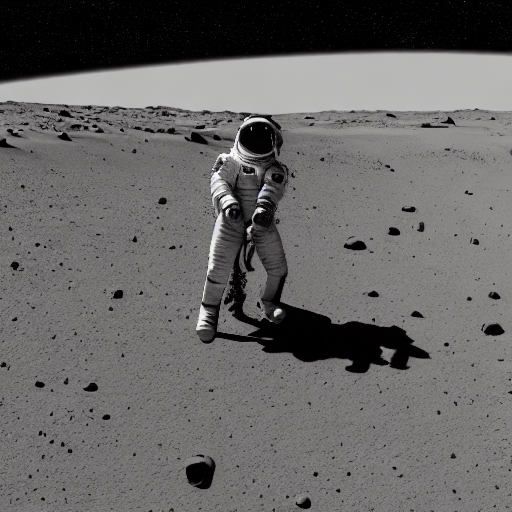

In [7]:
images[1].images[0]

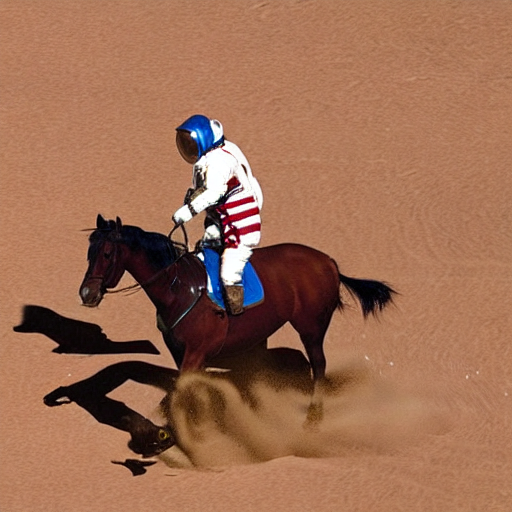

In [8]:
images[2].images[0]

In [9]:
images[0].images[0].size

(512, 512)

In [10]:
images[1].images[0].size

(512, 512)

* What is the size of the resulting images?
 * The size is 512 x 512

* In what ways do the 4 images you've generated so far vary? In what ways do the stay the same?
 * The images vary in the style (some look more like pictures, drawing, and other more realistic). Also the position or point of view of the astronaut is different.
 * The similarity is that all of them include the astronaut, the horse on mars probably (red ground).



# Step 2: Generating Images with Diffusion Models

Once we have our image generation model loaded, it's time to start experiment with it to understand it at a deeper level. As discussed in lecture and the reading, diffusion models generate images by "diffusing" noise iteratively, and there are **4 basic options** you can tweak in order to generate the kind of images you want

* The original "latent noise" matrix that is converted into the image. This is controlled by the  `latents` parameter in `pipe()`. By fixing this, you can generate reproducible images, so this is also known as the *seed*.
* The number of steps for which to denoise the image. This is controlled by the `num_inference_steps` parameter in `pipe()`. 
* The prompt itself: the most obvious thing to change is the prompt itself. This is more of an art than a science, but we recommend that you read some resources on how to design a good prompt, [such as this](https://www.howtogeek.com/833169/how-to-write-an-awesome-stable-diffusion-prompt/).
* The guidance scale: this parameter controls how much you want the resulting image to be controlled by your prompt versus "letting it do its own thing." This is controlled by the `guidance_scale` parameter in `pipe()`

We'll explore the effect of these parameters in this step of the project. You might find it helpful to take a look at the parameters accepted by the [pipeline](https://github.com/huggingface/diffusers/blob/f3983d16eed57e46742d217363d8913bef7f748d/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L112).

There is also (at least) **1 advanced option** that you can tweak in order to change the kinds of images

* The "scheduler" which is the specific way that a noisy image is diffused or denoised. We'll explore this in the extensions.  

### 2a. Setting the random seeds

First, we'll see how to set a random seed to control the latent noise matrix, which in turn controls the image that is generated. First, we will define a "generator" in PyTorch.

In [11]:
import torch
device = "cuda"
generator = torch.Generator(device=device)

seed = generator.seed()
print(f"The seed for this generator is: {seed}")

The seed for this generator is: 1199078799076759


Now, generate a random Tensor that using the `generator` above to feed into the `latents` parameter. For the default Stable Diffusion pipeline, it should be of size 1 x 4 x 64 x 64. Confirm that every time you generate this "random" generator, you get the same tensor.

You might find `torch.randn()` and `torch.equal` helpful methods.

In [19]:
random_tensor = torch.randn(size=(1, 4, 64, 64))

In [20]:
random_tensor

tensor([[[[-1.1126,  1.3718,  0.3159,  ..., -0.6988, -0.6634,  1.7252],
          [-0.2539, -0.2739, -0.3812,  ...,  0.2580,  0.1846,  0.0576],
          [-1.0957,  0.3754, -0.0655,  ...,  0.6762, -0.0631, -2.3519],
          ...,
          [ 0.1331, -0.2994,  1.9994,  ...,  0.5427,  0.1804,  2.3816],
          [-2.0932, -1.2338, -0.6851,  ...,  0.2410,  0.8630, -0.6776],
          [ 0.0395,  0.7617,  0.1244,  ..., -0.4437,  1.0085, -0.4570]],

         [[ 0.7892,  1.2668, -0.9113,  ...,  0.5302, -0.7671, -0.6544],
          [-0.5854,  1.4638,  1.6131,  ..., -1.4709,  0.1536, -0.9232],
          [-0.8481, -0.3456,  0.5886,  ...,  1.0672, -0.2826, -0.2498],
          ...,
          [-0.2376,  0.9467, -0.2547,  ..., -0.1283, -0.0914, -0.3508],
          [ 0.6865,  1.5403,  0.0833,  ..., -0.9725, -0.2482, -0.9469],
          [-0.6119, -1.0491,  0.5111,  ..., -2.5982, -1.4171,  1.7587]],

         [[ 0.4185, -0.2513, -0.0461,  ..., -0.3093,  0.6073,  0.9147],
          [ 0.0645, -0.5913, -

Now generate two images of astronauts on horses using the same latent noise matrix you defined above, and confirm that they are the same:

In [ ]:
# ANSWER HERE

### 2b. Setting the number of steps to generate the image

Next up, let's see how the number of steps controls the quality of the generated image. By default, the `pipe()` method runs for 50 steps. What happens if you run it for 5, 10, 25, 50, and 100 steps?

Generate images for each of these steps below ***using the same fixed latent noise*** 


In [ ]:
# ANSWER HERE

What is the tradeoff that you experience when increasing the number of steps for which to run the pipeline? [ANSWER]


### 2c. Choosing a Good Prompt

Next up, we're going to experiment with different prompts, and understand how they affect the image that is generated by Stable Diffusion. Since there is no exact science in generating prompts, it is helpful to see what kinds of prompts tend to do well. Visit a website of Stable Diffusion-generated art, such as https://lexica.art/ and you'll notice that most good prompts have the following two-part structure:

PROMPT = **Detailed Description of Object** + *Style Modifiers*

Here are a couple of examples:

* [**big window, mountains in background, cloud forest in background, tropical beach in background**, *sunset, warm golden hour lighting, holiday vibes, living room, furniture, IKEA catalogue, futuristic, ultra realistic, ultra detailed, cinematic light, anamorphic, wooden floored balcony, by Paul Lehr*](https://lexica.art/prompt/a8985a90-708a-4786-88cd-6dabad79737c)
* [**portrait of a super cute bunny, a carrot**, *pixar, zootopia, cgi, blade runner. trending on artstation*](https://lexica.art/prompt/8d078a31-2414-44d7-bab7-aa02067af61e)

Generally, the more details and style modifiers you provide, the better the final result.

For this part, we'd like you to generate a **movie poster** that does NOT exist in real life. It should star a real celebrity in a fictional movie, TV show, or setting that they do NOT act in.

You should start off with a simple prompt, such as: "*A movie poster of Robert Downey Jr in Downton Abbey*" (please choose a **different** celebrity and setting for your experiments). This might not get you a particularly realistic movie poster, so we'd like you to then add more details and stylistic modifiers to improve the generated images.

Please display the results of at least 5 different prompts below and try to get the best movie poster you can!

*Note*: you might end up with a completely black image if the "safety filter" of the StableDiffusion model has been triggered. In some cases, the "safety filter" might be too sensitive and flag an image even with a relatively safe prompt. Please try again with a slightly different prompt if you think that has happened. 



In [ ]:
# ANSWER HERE

### 2d. Choosing a Guidance Scale

The last parameter we need to understand is the guidance scale. Choosing a guidance scale affects how closely Stable Diffusion will stick to the prompt that you provide. The default value is `7.5`, but try the following guidance scales: `3`, `7`, `12`, and `20` to understand the tradeoffs between choosing different values:

In [ ]:
# ANSWER HERE

When should you choose a lower value for the guidance scale? When should you choose a higher value? [ANSWER HERE]

# Step 3: Improving Images of Faces

A well-known problem of ML-generated images is that faces and particularly *eyes* are usually not generated very realistically. We are going to solve this problem by... using MORE machine learning.

In particular, we are going to use the [GFP-GAN](https://huggingface.co/spaces/akhaliq/GFPGAN), a machine learning model that is designed to restore enhance old portraits. As it turns out, the model can ALSO be used to improve the faces and eyes in ML-generated images. 

For example, here is the image that I generated with the prompt above: "*A movie poster of Robert Downey Jr in Downton Abbey*"

![link text](https://i.ibb.co/qkCR6rp/bef.png)

After passing it through GFP-GAN, the eyes and faces were rendered far more realistically. As a side benefit of using GFP-GAN, the *resolution* of the image is also increased!

![link text](https://i.ibb.co/BZQ8bPq/aft.png)


So how can you use GFP-GAN? Well one way would be to drag-and-drop your image into the Gradio demo here: https://huggingface.co/spaces/akhaliq/GFPGAN 

But instead, we'd like for you to use the demo *programmatically*! Every Gradio demo comes with an API that you can use to make requests to it programmatically. You can see the documentation of this API by clicking the "view API" button at the bototm of the demo:

![](https://i.ibb.co/5BybtRt/image.png)

* For this step of the project, take the 5 images that you generated in Step 2, and pass them through the GFP-GAN demo programmatically. Display the original images alongside the "enhanced" images:

(Note that if this demo has a long queue, you could use another version of the GFPGAN Space such as https://huggingface.co/spaces/NotFungibleIO/GFPGAN)

*Hint*: we suggest using the `requests` library to make POST requests to the GFP-GAN demo and the `base64` library to convert images to and from base64 format.

In [ ]:
import requests
import base64

def improve_image(img):
  # ANSWER HERE

* What is the resolution of your original images? What is the resolution of the images after they have been processed by GFP-GAN? [ANSWER HERE]

# Step 4: Building a Machine Learning Web App

Now, we finally have all of the pieces to build our Gradio machine learning app. Build (and launch!) a Gradio app that accepts the following:

* A textbox for a celebrity name
* A dropdown with a list of movies, TV shows, or settings

And produces the following output:

* An image of a movie poster starring that celebrity in that movie/show/setting. 

Use the best prompt structure that you discovered in Step 2, and pass the image through GFP-GAN before returning it to the output, as in Step 3.

In [ ]:
import gradio as gr

def generate(celebrity, setting):
  # ANSWER HERE
  return image

gr.Interface(
  # ANSWER HERE    
)  

# Step 5: Collecting Data to Improve the Model

When trying out our demo, we might find that some celebrities or movies may not produce very realistic images. For example, this might happen with less famous celebrities if Stable Diffusion does not "know" enough about them. Or it could be signs of bias in the data, as discussed in Week 3. As a result, we may want users to be able to FLAG those prompts and save the resulting data in a HuggingFace Dataset so that we can improve the model's performance (this is explored further in the second extension, **Textual Inversion**).

In this Step, we will adapt our Gradio demo from Step 4 to be able to save generated images. Please take a look at: https://gradio.app/using_flagging/#the-huggingfacedatasetsaver-callback and fill in the following code:

In [ ]:
import gradio as gr

import os

HF_TOKEN = os.getenv('HF_TOKEN')
hf_writer = # ANSWER HERE

gr.Interface(
  # ANSWER HERE    
)

Flag a few example images and ensure that they appear in your Hugging Face Dataset. 

* What is the URL to your dataset: [ANSWER HERE]

Please make sure that the dataset is **public**

# Bonus: Extensions

* **Schedulers**: The `diffusers` library includes support for different schedulers, [as described here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers). Which other schedulers are compatible with the `StableDiffusion` model? Experiment with a few of these schdulers -- what tradeoffs do you notice between different schedulers?
* **Textual Inversion**: There are some names or "concepts" that Stable Diffusion doesn't know about. For example, unless you are famous, Stable Diffusion may not know your name. Or the model might not know one of the celebrities in your training dataset from last week. You can "teach" StableDiffusion new concepts by uploading a few images using a technique called Textual Inversion. Teach Stable Diffusion either the name of a celebrity (you can use your dataset from last week) or your own name [using Textual Inversion](https://huggingface.co/docs/diffusers/training/text_inversion), and then display movie posters generated by the original Stable Diffusion versus your new version. 
* **Your own GFP-GAN Space**: If you find that all of the GFP-GAN demos on Spaces have a long queue, you might want to clone your own version of the GFP-GAN Space, and run it to get your own private demo. Do that (you might find this [repo duplicator](https://huggingface.co/spaces/osanseviero/repo_duplicator) useful) and then use it for your own API.
* **Use a different model than StableDiffusion**: in this entire project, we used StableDiffusion. Try using a different diffusion model to generate images -- what tradeoffs do you notice with the other model?



---


#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).